In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# XGBoost (opcional)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

In [2]:
WINDOW_SIZE = 5          # retrospecto recente por time
H2H_WINDOW = 5           # confronto direto (últimos N jogos entre eles)
RETA_FINAL_TH = 0.75     # >= 75% do campeonato

In [ ]:
print("Carregando dados...")
df_full = pd.read_csv('/Users/rodrigokauer/Desktop/tcc/dataset/campeonato-brasileiro-full.csv')
df_stats = pd.read_csv('/Users/rodrigokauer/Desktop/tcc/dataset/campeonato-brasileiro-estatisticas-full.csv')

df_full['data'] = pd.to_datetime(df_full['data'], dayfirst=True)

def clean_percent(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        return float(x.replace('%', ''))
    return x

df_stats['posse_de_bola'] = df_stats['posse_de_bola'].apply(clean_percent)
df_stats['precisao_passes'] = df_stats['precisao_passes'].apply(clean_percent)

stats_cols = ['chutes', 'chutes_no_alvo', 'posse_de_bola', 'passes', 'precisao_passes', 'escanteios', 'faltas']

for col in stats_cols:
    df_stats[col] = df_stats[col].replace(0, np.nan)

cols_match = ['ID', 'data', 'mandante', 'visitante', 'mandante_Placar', 'visitante_Placar']
df_partidas = df_full[cols_match].copy()

condicoes = [
    df_partidas['mandante_Placar'] > df_partidas['visitante_Placar'],
    df_partidas['mandante_Placar'] == df_partidas['visitante_Placar'],
    df_partidas['mandante_Placar'] < df_partidas['visitante_Placar']
]
df_partidas['target'] = np.select(condicoes, [2, 1, 0])

df_partidas = df_partidas.sort_values('data').reset_index(drop=True)

Carregando dados...


In [ ]:
# momento do camp
df_partidas['ano'] = df_partidas['data'].dt.year
df_partidas['rodada'] = df_partidas.groupby('ano').cumcount() + 1
df_partidas['rodadas_no_ano'] = df_partidas.groupby('ano')['rodada'].transform('max')
df_partidas['fase_campeonato'] = df_partidas['rodada'] / df_partidas['rodadas_no_ano']
df_partidas['reta_final'] = (df_partidas['fase_campeonato'] >= RETA_FINAL_TH).astype(int)

# confronto regional
TEAM_STATE = {
    # RJ
    'Flamengo': 'RJ', 'Fluminense': 'RJ', 'Vasco': 'RJ', 'Botafogo': 'RJ',
    # SP
    'Palmeiras': 'SP', 'Corinthians': 'SP', 'São Paulo': 'SP', 'Santos': 'SP',
    # MG
    'Atlético-MG': 'MG', 'Cruzeiro': 'MG',
    # RS
    'Grêmio': 'RS', 'Internacional': 'RS',
    # PR
    'Athletico-PR': 'PR', 'Coritiba': 'PR',
    # BA
    'Bahia': 'BA', 'Vitória': 'BA',
    # SC
    'Figueirense': 'SC', 'Avaí': 'SC',
    # CE
    'Ceará': 'CE', 'Fortaleza': 'CE',
    # PE
    'Sport': 'PE', 'Náutico': 'PE', 'Santa Cruz': 'PE',
    # GO
    'Goiás': 'GO', 'Atlético-GO': 'GO',

}

df_partidas['uf_mandante'] = df_partidas['mandante'].map(TEAM_STATE)
df_partidas['uf_visitante'] = df_partidas['visitante'].map(TEAM_STATE)
df_partidas['confronto_regional'] = (df_partidas['uf_mandante'] == df_partidas['uf_visitante']).astype(float)
# float para permitir NaN se algum time não estiver no dicionário


# confronto direto 
print("Calculando features de confronto direto (H2H)...")

df_h2h_base = df_partidas[['data', 'mandante', 'visitante', 'mandante_Placar', 'visitante_Placar']].copy()

def h2h_features(row, window=H2H_WINDOW):
    a = row['mandante']
    b = row['visitante']
    dt = row['data']

    mask = (
        (((df_h2h_base['mandante'] == a) & (df_h2h_base['visitante'] == b)) |
         ((df_h2h_base['mandante'] == b) & (df_h2h_base['visitante'] == a)))
        & (df_h2h_base['data'] < dt)
    )

    hist = df_h2h_base.loc[mask].sort_values('data').tail(window)

    if hist.empty:
        return pd.Series({
            'h2h_jogos_ult_n': 0,
            'h2h_vitorias_mandante_ult_n': 0,
            'h2h_vitorias_visitante_ult_n': 0,
            'h2h_empates_ult_n': 0,
            'h2h_saldo_gols_mandante_ult_n': 0
        })

    # computar resultado do ponto de vista do "mandante do jogo atual"
    h2h_win_home = 0
    h2h_win_away = 0
    h2h_draws = 0
    saldo = 0

    for _, r in hist.iterrows():
        # gols do A e do B naquela partida (A=mandante atual, B=visitante atual)
        if r['mandante'] == a and r['visitante'] == b:
            gols_a = r['mandante_Placar']
            gols_b = r['visitante_Placar']
        elif r['mandante'] == b and r['visitante'] == a:
            gols_a = r['visitante_Placar']
            gols_b = r['mandante_Placar']
        else:
            continue

        saldo += (gols_a - gols_b)

        if gols_a > gols_b:
            h2h_win_home += 1
        elif gols_a < gols_b:
            h2h_win_away += 1
        else:
            h2h_draws += 1

    return pd.Series({
        'h2h_jogos_ult_n': len(hist),
        'h2h_vitorias_mandante_ult_n': h2h_win_home,
        'h2h_vitorias_visitante_ult_n': h2h_win_away,
        'h2h_empates_ult_n': h2h_draws,
        'h2h_saldo_gols_mandante_ult_n': saldo
    })

h2h_df = df_partidas.apply(h2h_features, axis=1)
df_partidas = pd.concat([df_partidas, h2h_df], axis=1)

Calculando features de confronto direto (H2H)...


In [ ]:
print("Gerando dataset por time (mandante/visitante) + rolling...")

def prepare_team_stats(df, is_home):
    team_col = 'mandante' if is_home else 'visitante'
    opp_col = 'visitante' if is_home else 'mandante'
    goals_pro = 'mandante_Placar' if is_home else 'visitante_Placar'
    goals_con = 'visitante_Placar' if is_home else 'mandante_Placar'

    cols = ['ID', 'data', team_col, opp_col, goals_pro, goals_con, 'target', 'ano']
    df_team = df[cols].copy()
    df_team.rename(columns={
        team_col: 'time',
        opp_col: 'oponente',
        goals_pro: 'gols_pro',
        goals_con: 'gols_sofridos'
    }, inplace=True)

    # pontos do ponto de vista do time na partida
    if is_home:
        df_team['pontos'] = np.where(df_team['target'] == 2, 3, np.where(df_team['target'] == 1, 1, 0))
    else:
        df_team['pontos'] = np.where(df_team['target'] == 0, 3, np.where(df_team['target'] == 1, 1, 0))

    # resultado (W/D/L) do ponto de vista do time
    df_team['win'] = (df_team['pontos'] == 3).astype(int)
    df_team['draw'] = (df_team['pontos'] == 1).astype(int)
    df_team['loss'] = (df_team['pontos'] == 0).astype(int)

    # forma: +1 vitória, 0 empate, -1 derrota
    df_team['forma1'] = np.select(
        [df_team['win'] == 1, df_team['draw'] == 1, df_team['loss'] == 1],
        [1, 0, -1],
        default=0
    )

    df_team['is_home'] = int(is_home)
    return df_team

home = prepare_team_stats(df_partidas, is_home=True)
away = prepare_team_stats(df_partidas, is_home=False)

df_team_matches = pd.concat([home, away]).sort_values(['time', 'data']).reset_index(drop=True)

# merge stats do jogo (por time)
df_team_matches = df_team_matches.merge(
    df_stats[['partida_id', 'clube'] + stats_cols],
    left_on=['ID', 'time'],
    right_on=['partida_id', 'clube'],
    how='left'
)

# rolling geral (últimos WINDOW_SIZE) do time (independente de casa/fora)
features_to_roll = ['gols_pro', 'gols_sofridos', 'pontos'] + stats_cols + ['win', 'draw', 'loss', 'forma1']

grouped = df_team_matches.groupby('time')

rolling_stats = grouped[features_to_roll].apply(
    lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).mean().shift(1)
).reset_index(level=0, drop=True)

new_cols = [f'media_{col}_ult_{WINDOW_SIZE}' for col in features_to_roll]
rolling_stats.columns = new_cols

df_team_features = pd.concat([df_team_matches, rolling_stats], axis=1)

# Rolling específico por CASA/FORA (desempenho como mandante e como visitante)
grouped_side = df_team_features.groupby(['time', 'is_home'])

side_roll = grouped_side[features_to_roll].apply(
    lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).mean().shift(1)
).reset_index(level=[0, 1], drop=True)

side_cols = [f'media_side_{col}_ult_{WINDOW_SIZE}' for col in features_to_roll]
side_roll.columns = side_cols

df_team_features = pd.concat([df_team_features, side_roll], axis=1)

# manter só colunas finais por time/jogo
cols_to_keep = ['ID', 'time', 'is_home'] + new_cols + side_cols
df_features_final = df_team_features[cols_to_keep].copy()

Gerando dataset por time (mandante/visitante) + rolling...


In [6]:
print("Montando df_final com features home/away + partida...")

# merge mandante
df_final = df_partidas.merge(
    df_features_final,
    left_on=['ID', 'mandante'],
    right_on=['ID', 'time'],
    how='left'
).drop(columns=['time'])

# renomear colunas do mandante (prefixo home_)
rename_home = {c: f'home_{c}' for c in (new_cols + side_cols)}
df_final.rename(columns=rename_home, inplace=True)

# merge visitante
df_final = df_final.merge(
    df_features_final,
    left_on=['ID', 'visitante'],
    right_on=['ID', 'time'],
    how='left',
    suffixes=('', '_tmp')
).drop(columns=['time'])

rename_away = {c: f'away_{c}' for c in (new_cols + side_cols)}
df_final.rename(columns=rename_away, inplace=True)

# (opcional) remover colunas auxiliares de UF
df_final.drop(columns=['uf_mandante', 'uf_visitante'], inplace=True, errors='ignore')

Montando df_final com features home/away + partida...


In [ ]:
print("\nPreparando modelagem binária (sem empates)...")

df_model = df_final.sort_values('data').copy()

# remover empates
df_model = df_model[df_model['target'] != 1].copy()

# target binário: 1=mandante vence, 0=visitante vence
df_model['target_bin'] = (df_model['target'] == 2).astype(int)

# encoding times
le = LabelEncoder()
all_teams = pd.concat([df_model['mandante'], df_model['visitante']]).unique()
le.fit(all_teams)
df_model['mandante_code'] = le.transform(df_model['mandante'])
df_model['visitante_code'] = le.transform(df_model['visitante'])

# features: códigos + todas as colunas de rolling + features de partida
feature_cols = (
    ['mandante_code', 'visitante_code',
     'rodada', 'fase_campeonato', 'reta_final', 'confronto_regional',
     'h2h_jogos_ult_n', 'h2h_vitorias_mandante_ult_n', 'h2h_vitorias_visitante_ult_n',
     'h2h_empates_ult_n', 'h2h_saldo_gols_mandante_ult_n']
    +
    [c for c in df_model.columns if c.startswith('home_media_') or c.startswith('away_media_')
     or c.startswith('home_media_side_') or c.startswith('away_media_side_')]
)

X = df_model[feature_cols]
y = df_model['target_bin']

# split temporal
split_idx = int(len(X) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("\nDistribuição de classes:")
print("Treino:\n", y_train.value_counts())
print("Teste:\n", y_test.value_counts())

if y_train.nunique() < 2:
    raise ValueError(
        "y_train ficou com apenas 1 classe após remover empates e split temporal.\n"
        "Sugestões: ajuste split (ex. 70/30) ou escolha um corte por data que preserve 0 e 1 no treino."
    )

# modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=400, max_depth=12, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME', random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=20),
    'MLP': MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=800, random_state=42)
}

if xgb_available:
    models['XGBoost'] = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9
    )

print("\nTreinando modelos (binário, sem empates)...")
results = []
reports = {}

for name, model in models.items():
    print(f"Treinando {name}...")

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    pipeline.fit(X_train_raw, y_train)
    y_pred = pipeline.predict(X_test_raw)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)

    results.append({
        'Modelo': name,
        'Acurácia': acc,
        'Precisão': prec,
        'Recall': rec,
        'F1': f1
    })

    reports[name] = classification_report(
        y_test, y_pred,
        target_names=['Visitante vence (0)', 'Mandante vence (1)'],
        zero_division=0
    )

results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print("\n=== RANKING DE MODELOS (ordenado por F1) ===")
print(results_df)

best_model_name = results_df.iloc[0]['Modelo']
print(f"\n=== CLASSIFICATION REPORT: {best_model_name} ===")
print(reports[best_model_name])


Preparando modelagem binária (sem empates)...

Distribuição de classes:
Treino:
 target_bin
1    3539
0    1631
Name: count, dtype: int64
Teste:
 target_bin
1    820
0    473
Name: count, dtype: int64

Treinando modelos (binário, sem empates)...
Treinando Logistic Regression...
Treinando Random Forest...
Treinando Gradient Boosting...
Treinando AdaBoost...


/Users/rodrigokauer/Desktop/tcc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Treinando Naive Bayes...
Treinando SVM...
Treinando KNN...
Treinando MLP...
Treinando XGBoost...

=== RANKING DE MODELOS (ordenado por F1) ===
                Modelo  Acurácia  Precisão    Recall        F1
3             AdaBoost  0.652746  0.652174  0.969512  0.779794
5                  SVM  0.647332  0.647488  0.974390  0.777994
1        Random Forest  0.646558  0.651376  0.952439  0.773650
6                  KNN  0.646558  0.661621  0.906098  0.764797
0  Logistic Regression  0.640371  0.654752  0.915854  0.763599
8              XGBoost  0.640371  0.656664  0.907317  0.761905
2    Gradient Boosting  0.634184  0.655327  0.892683  0.755808
7                  MLP  0.576953  0.663866  0.674390  0.669087
4          Naive Bayes  0.576953  0.719101  0.546341  0.620929

=== CLASSIFICATION REPORT: AdaBoost ===
                     precision    recall  f1-score   support

Visitante vence (0)       0.66      0.10      0.18       473
 Mandante vence (1)       0.65      0.97      0.78       820

 

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



Preparando cenário BINÁRIO (sem empates)...
Distribuição BINÁRIA (teste):
target_bin
0    473
1    820
Name: count, dtype: int64

Gerando matrizes de confusão (BINÁRIO)...
Matriz de Confusão - Logistic Regression
[[ 77 396]
 [ 69 751]]


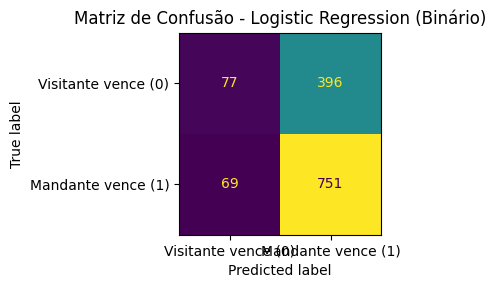

Matriz de Confusão - Random Forest
[[ 55 418]
 [ 39 781]]


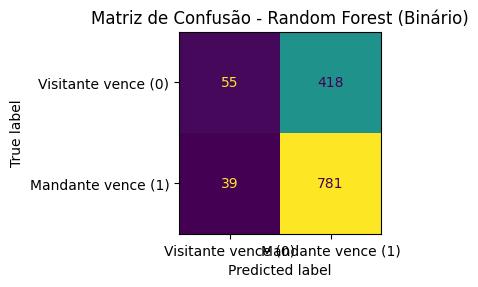

Matriz de Confusão - Gradient Boosting
[[ 88 385]
 [ 88 732]]


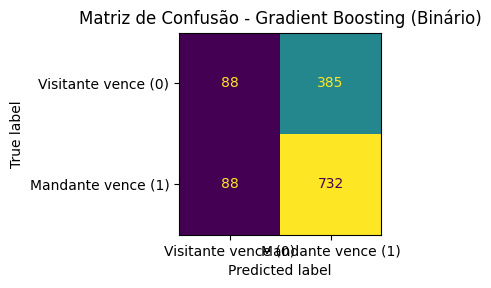

Matriz de Confusão - AdaBoost
[[ 49 424]
 [ 25 795]]


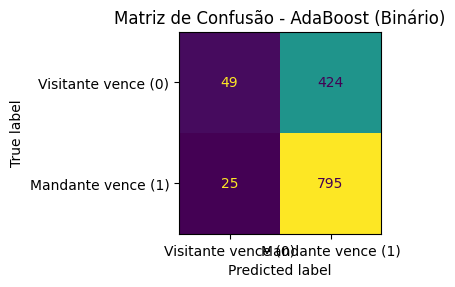

Matriz de Confusão - Naive Bayes
[[298 175]
 [372 448]]


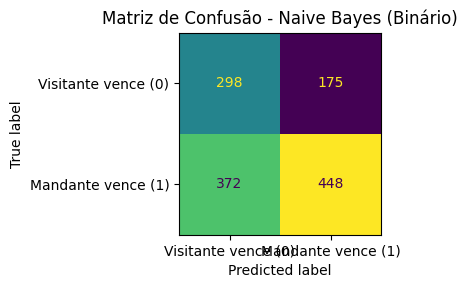

Matriz de Confusão - SVM
[[ 38 435]
 [ 21 799]]


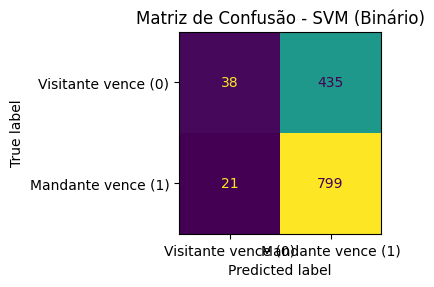

Matriz de Confusão - KNN
[[ 93 380]
 [ 77 743]]


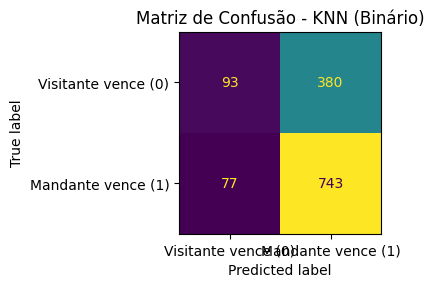

Matriz de Confusão - MLP
[[193 280]
 [267 553]]


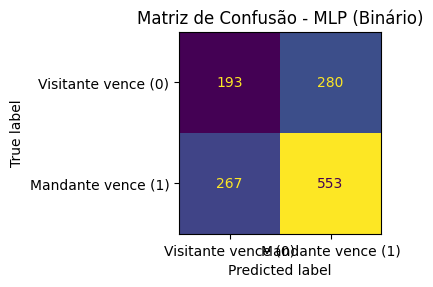

Matriz de Confusão - XGBoost
[[ 84 389]
 [ 76 744]]


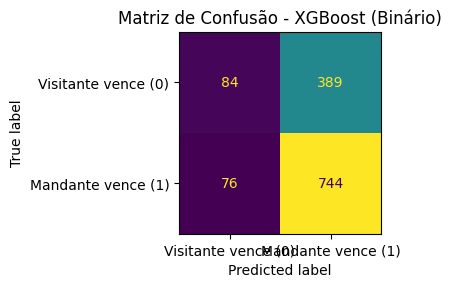

In [9]:
print("\nPreparando cenário BINÁRIO (sem empates)...")

df_bin = df_model[df_model['target'] != 1].copy()
df_bin['target_bin'] = (df_bin['target'] == 2).astype(int)

Xb = df_bin[feature_cols]
yb = df_bin['target_bin']

split_idx = int(len(Xb) * 0.8)
Xb_train, Xb_test = Xb.iloc[:split_idx], Xb.iloc[split_idx:]
yb_train, yb_test = yb.iloc[:split_idx], yb.iloc[split_idx:]

print("Distribuição BINÁRIA (teste):")
print(yb_test.value_counts().sort_index())

# modelos binários (mesmos, sem ajuste especial)
models_bin = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=400, max_depth=12, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=20),
    'MLP': MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=800, random_state=42)
}

if xgb_available:
    models_bin['XGBoost'] = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9
    )

print("\nGerando matrizes de confusão (BINÁRIO)...")

conf_matrices_bin = {}

for name, model in models_bin.items():
    print(f"Matriz de Confusão - {name}")

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    pipeline.fit(Xb_train, yb_train)
    yb_pred = pipeline.predict(Xb_test)

    cm = confusion_matrix(yb_test, yb_pred, labels=[0, 1])
    conf_matrices_bin[name] = cm

    print(cm)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[
            'Visitante vence (0)',
            'Mandante vence (1)'
        ]
    )

    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap=None, colorbar=False, values_format='d')
    ax.set_title(f"Matriz de Confusão - {name} (Binário)")
    plt.tight_layout()
    plt.show()
